In [1]:
### Import libraries and set plot style

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
colors = ['#202020', '#d62728', '#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#bcbd22', '#e377c2', '#17becf', '#1f5a0a', '#8c564b', '#7f7f7f']
         ## black    red        blue       green      orange     violet     yellow     pink       lightblue  darkgreen  dirty-red  grey
plt.rcParams.update({'font.size': 7,
                     'axes.labelpad': 5,
                     'axes.labelsize': 8,
                     'xtick.labelsize' : 7,
                     'ytick.labelsize' : 7,
                     'axes.prop_cycle': cycler('color', colors),
                     #'axes.grid': True,
                     'axes.linewidth': 0.5,
                     'lines.linewidth': 0.5,
                     'lines.markersize': 2,
                     'scatter.marker': 'o',
                     #'errorbar.capsize': 2,
                     'figure.dpi': 200.0,
                     'figure.figsize': [5, 3],
                     'xtick.top' : True,
                     'ytick.right' : True,
                     'xtick.direction' : 'out',
                     'ytick.direction' : 'out',
                     'xtick.major.size': 2,
                     'xtick.minor.size': 1,
                     'ytick.major.size': 2,
                     'ytick.minor.size': 1,
                     'xtick.major.width': 0.5,
                     'xtick.minor.width': 0.2,
                     'ytick.major.width': 0.5,
                     'ytick.minor.width': 0.2})

In [2]:
### Import raw data and define measurement specifications

SAMPLE = "silica, 7nm pores, 20 wt.% PEI"
# specify what temperatures where used and in what order
TEMPS = [70, 50, 30]
GASES = ["N$_2$", "CO$_2$"]
# specify which gas is used in which run: N_2 -> 0, CO_2 -> 1 (specified in "GASES")
# rows: measurements with fixed temperature, same order as "TEMPS" above
# columns: runs
# (compatability) the same gas may be used twice in a row
S = [[1, 0, 1, 0],
     [1, 0, 1, 0],
     [0, 1, 0, 1, 0]]
# specify the starting times of the runs
# sometimes the measurement doesn't start at t=0: set GASCHANGE[0] to cut out degassing phase, otherwise set 0 as first value
# After that, put time in seconds for every time the gas is changed (or new ballon with same gas)
GASCHANGE = [[0, 6989, 16205, 25988],
             [1.8848e+04, 19289, 25645, 33843],
             [7.0136e+03, 10697, 18196, 25623, 32600]]
# indices (columns) of frequency, epsilon' (er), epsilon'' (ei) and time in ascii file
f_ind, er_ind, ei_ind, t_ind = 0, 2, 3, -1

# specify folder and filenames of raw data, files in same order as "TEMPS" above
folder = "Messdaten PEI20/"
files = ["13-10_M2_TBD031_PEI20_70C_CNCN.TXT",
         "13-13_M1_TBD031_PEI20_50C_NdryCNCN.TXT",
         "13-14_M2_TBD031_PEI20_30C_NdryCNCN.TXT"]
DATA = [[], [], []]

for m, f in enumerate(files) :
     # import ascii data, usually it has a header of 4 lines that is cut out
     data_ = np.genfromtxt(folder+f, delimiter='\t', skip_header=4)

     # remove points before start of first run
     after = data_[:,-1] >= GASCHANGE[m][0]
     data = data_[after]

     # add final time to GASCHANGE, needed in main and make time unit hours
     GASCHANGE[m].append(data[-1,-1])
     GASCHANGE[m] = np.array(GASCHANGE[m]) / 60.
     data[:,-1] = data[:,-1] / 60.

     DATA[m] = data

In [ ]:
### Data processing


def interpolate_x_vectorized(t, x, t_values):
    """Interpolates x at multiple t_values using a dynamically determined radius."""
    dt = np.max(t) / (len(t) - 1)  # Compute delta t
    interpol_radius = 1.7*dt
    
    # Find the indices of the closest points
    is_close = np.abs(t[:, None] - t_values) < interpol_radius  # Boolean mask for all t_values
    
    # Extract valid t and x values
    t_valid = [t[mask] for mask in is_close.T]
    x_valid = [x[mask] for mask in is_close.T]
    
    # Perform vectorized interpolation
    interpolators = [interp1d(t_v, x_v, kind='linear', fill_value="extrapolate") if len(t_v) > 1 else (lambda t0: x_v[0])
                     for t_v, x_v in zip(t_valid, x_valid)]
    
    return np.array([f(t_i) for f, t_i in zip(interpolators, t_values)])

fOut = [5e5]
def process_and_compute_derivative(data, num_points=1000):
    """Extracts unique F_k, interpolates x_k, computes derivatives along ln(F), and optimizes processing."""
    
    # Extract unique F_k values
    # ignore frequencies specified in fOut
    unique_F = np.unique(data[:, f_ind])
    mask = ~np.isin(unique_F, fOut)
    unique_F = unique_F[mask]
    lnw = np.log(2*np.pi*unique_F)  # Compute ln(F)
    
    # er: real part of epsilon; ei: imag. part; t: corresponding measured time
    er_list, ei_list, t_list = [], [], []

    # Group er_k, ei_k and t_k based on unique F_k
    for F_k in unique_F:
        mask = data[:, 0] == F_k
        er_k = data[mask][:, er_ind]
        ei_k = data[mask][:, ei_ind]
        t_k = data[mask][:, t_ind]
        er_list.append(er_k)
        ei_list.append(ei_k)
        t_list.append(t_k)

    # Generate `num_points` equidistant t_i values
    t_values = np.linspace(data[0,-1], data[-1,-1], num_points)

    # Interpolate er_k/ei_k values at all t_i
    interpolated_er = np.array([interpolate_x_vectorized(t_k, er_k, t_values) for t_k, er_k in zip(t_list, er_list)])
    interpolated_ei = np.array([interpolate_x_vectorized(t_k, ei_k, t_values) for t_k, ei_k in zip(t_list, ei_list)])

    # Compute gradient of er_k along ln(F)
    er_der =  -np.pi/2 * np.gradient(interpolated_er, lnw, axis=0)
    #er_der =  -np.pi/2 * np.gradient(interpolated_er, lnw, axis=0)

    return unique_F, er_der.T, interpolated_ei.T, t_values

def round_sig(x, n):
    if x == 0:
        return 0
    return float(round(x, n - int(__import__('math').floor(__import__('math').log10(abs(x)))) - 1))

def exps(x, a, b, c, d, e) :
    return np.exp(-b*(x-a)) + c - np.exp(-d*(x-e))
def expp(x, a, b, c) :
    return np.exp(-b*(x-a)) + c
def expn(x, c, d, e) :
    return c - np.exp(-d*(x-e))

/tmp/ipykernel_177251/2433341266.py:23: RuntimeWarning: invalid value encountered in log
  ln_er_der = np.log(er_der)


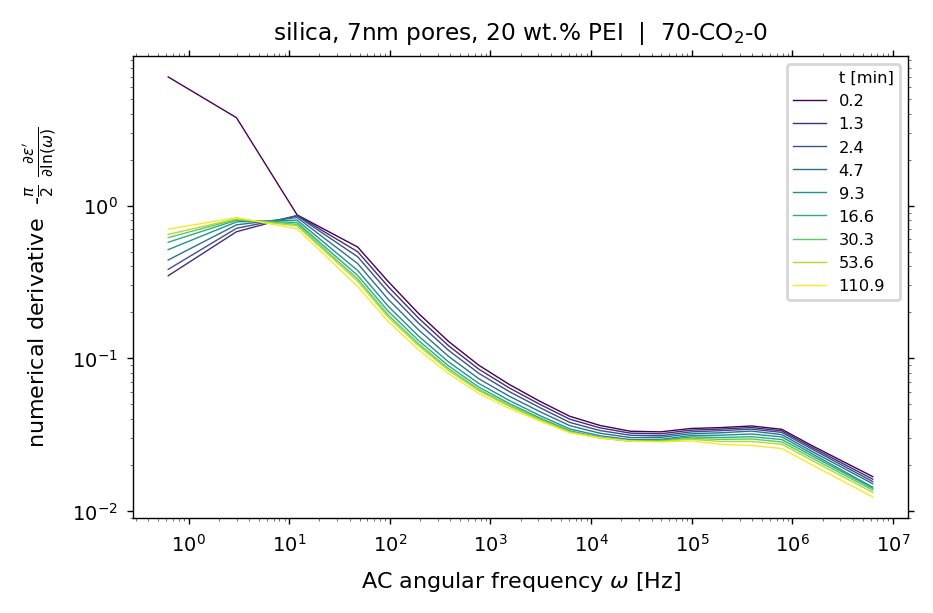

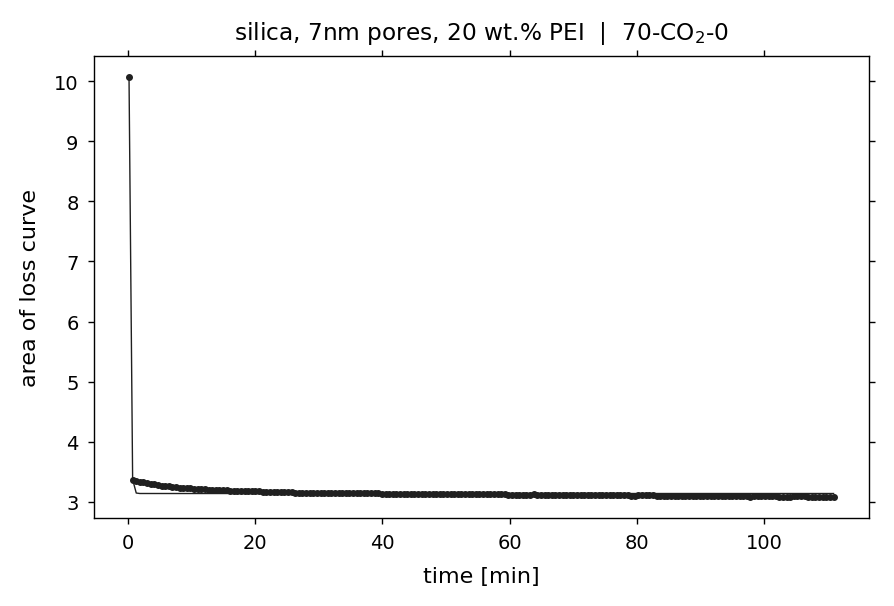

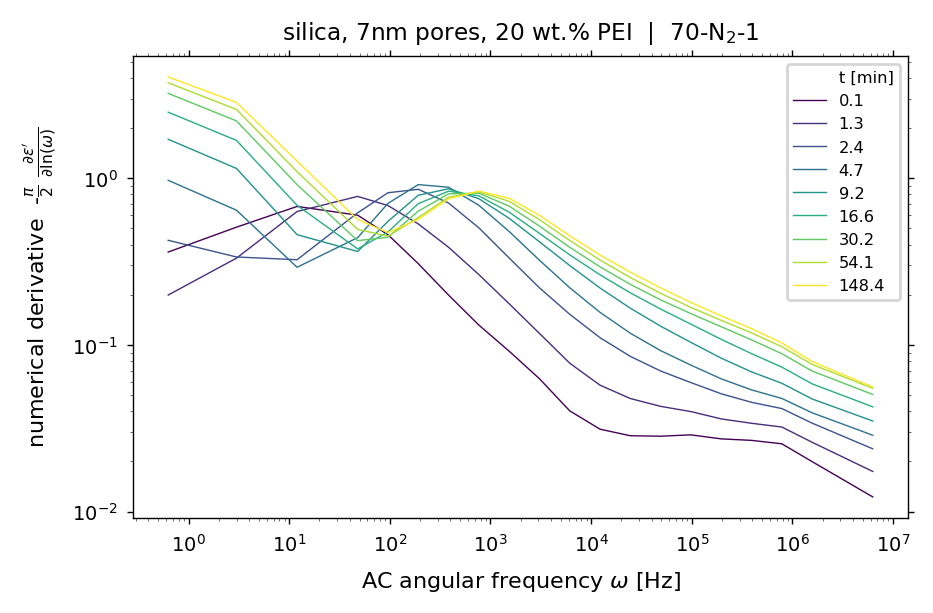

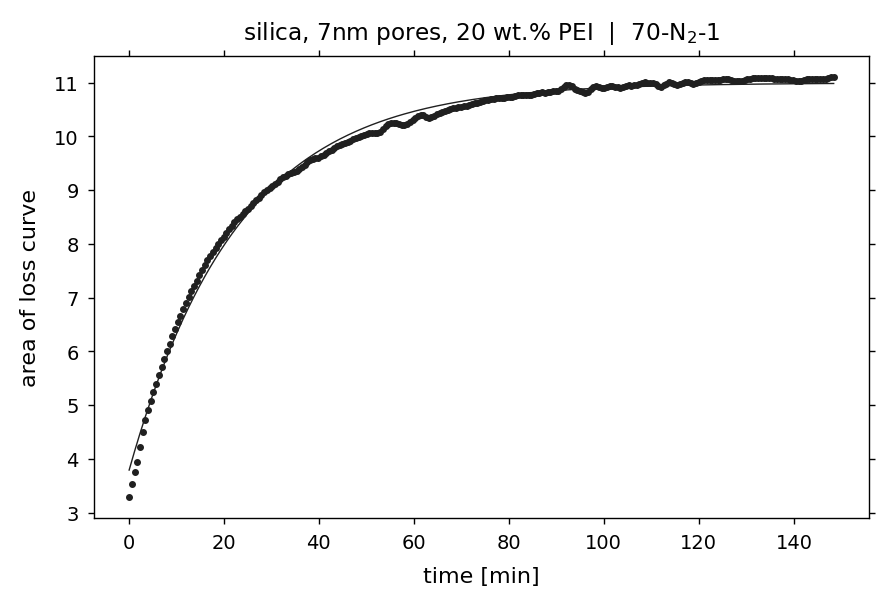

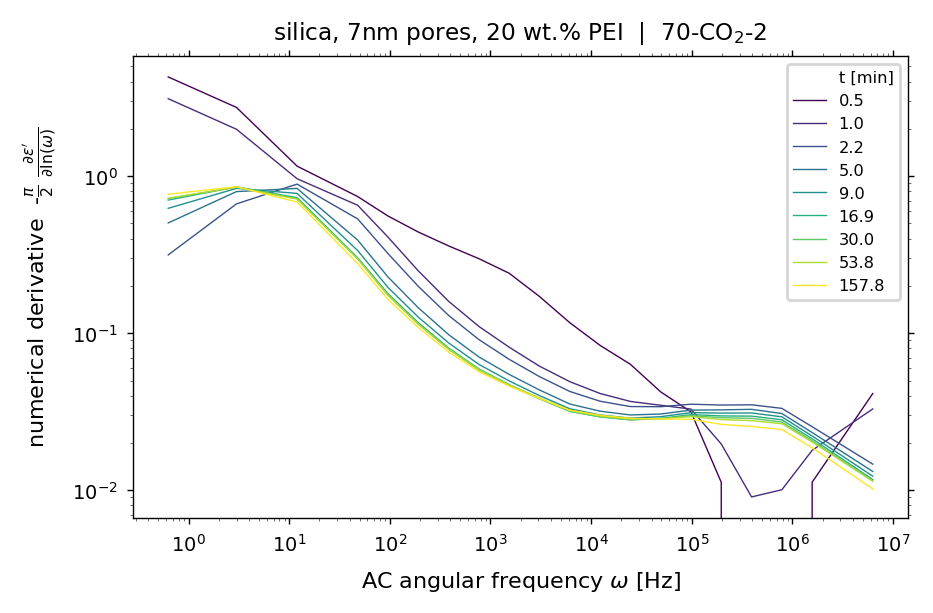

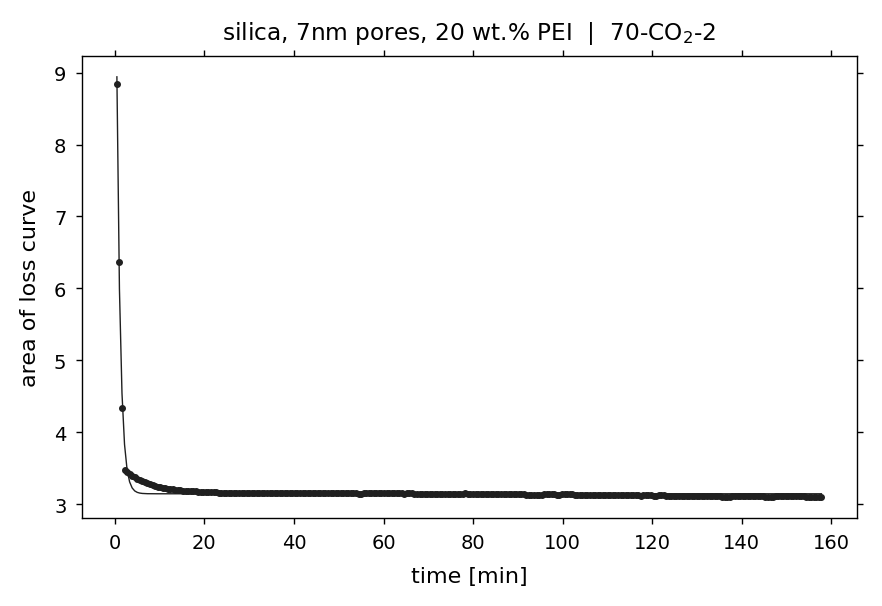

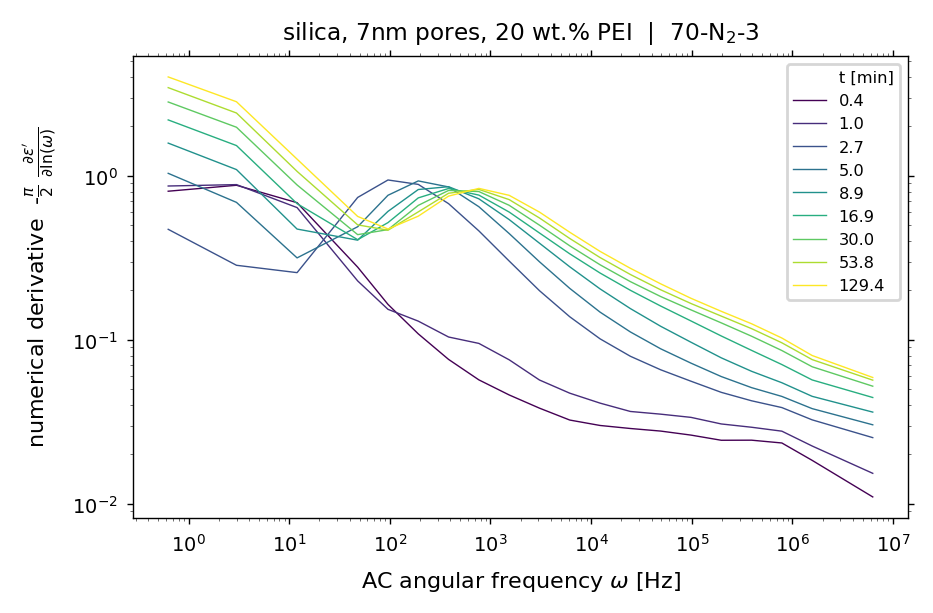

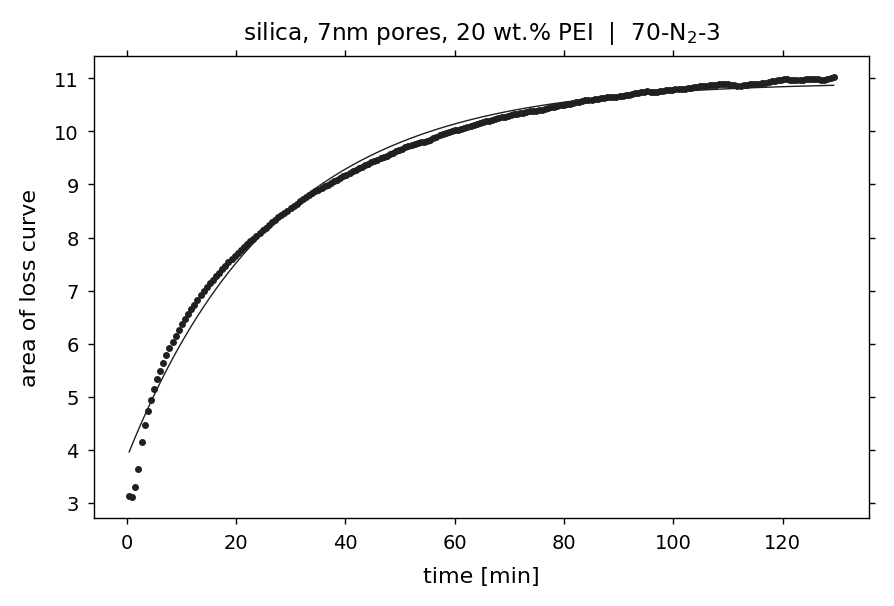

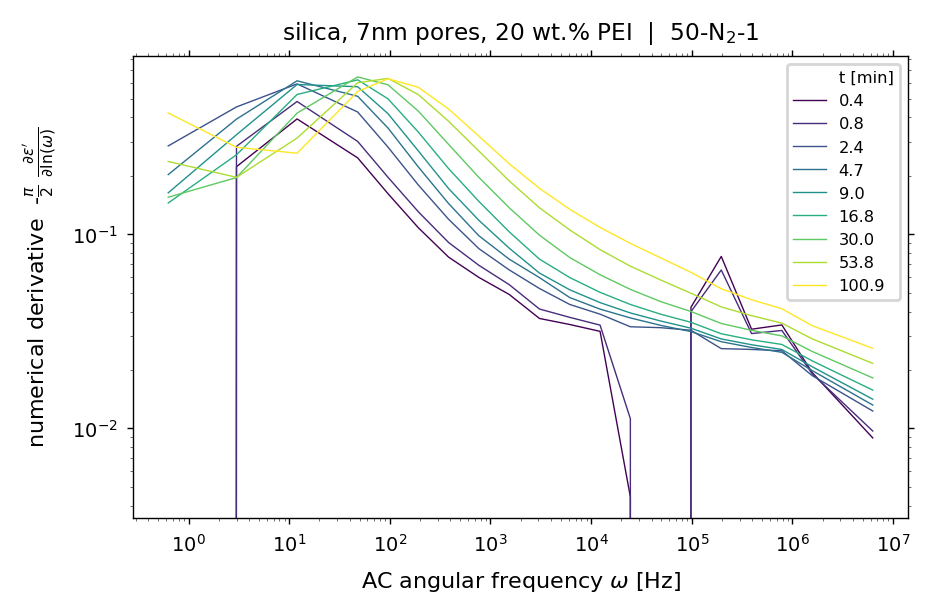

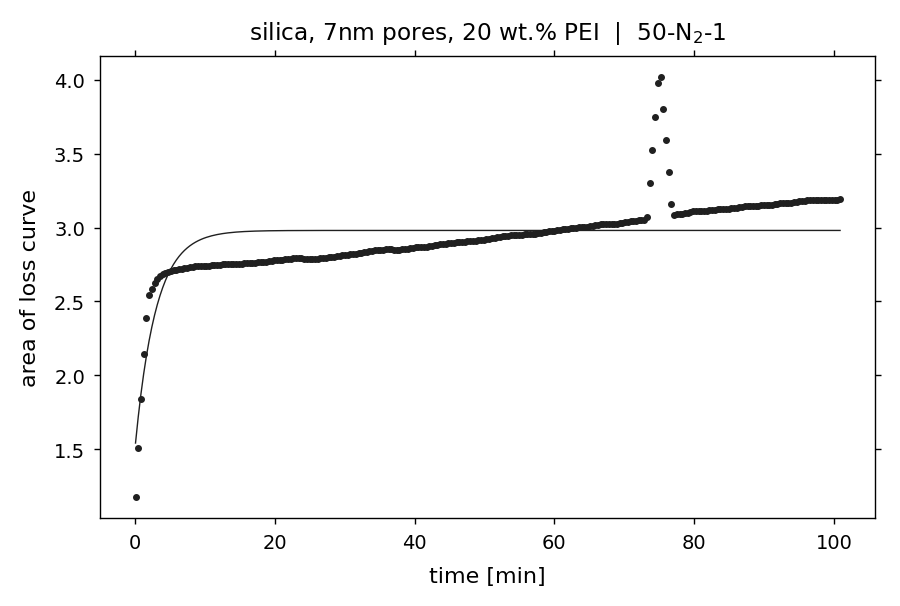

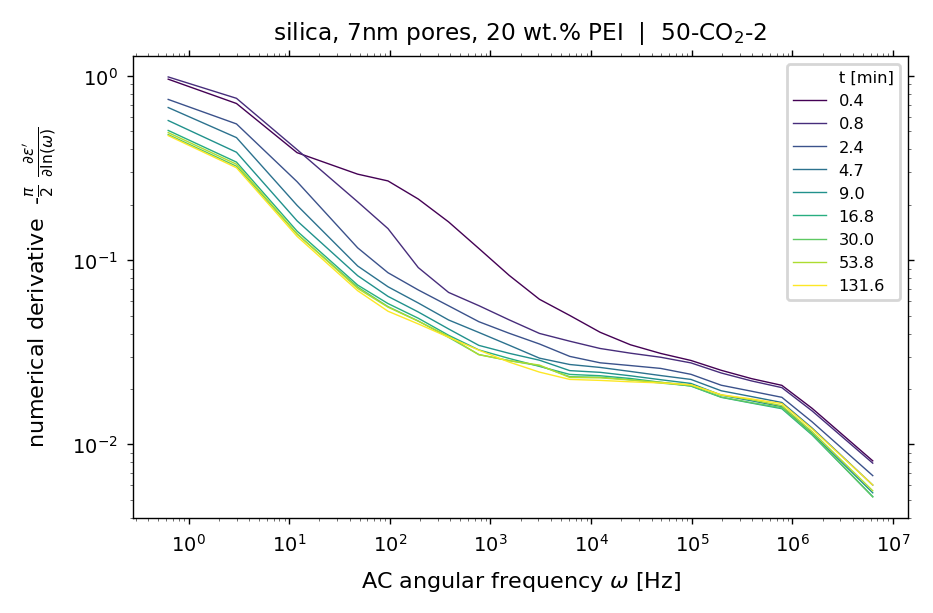

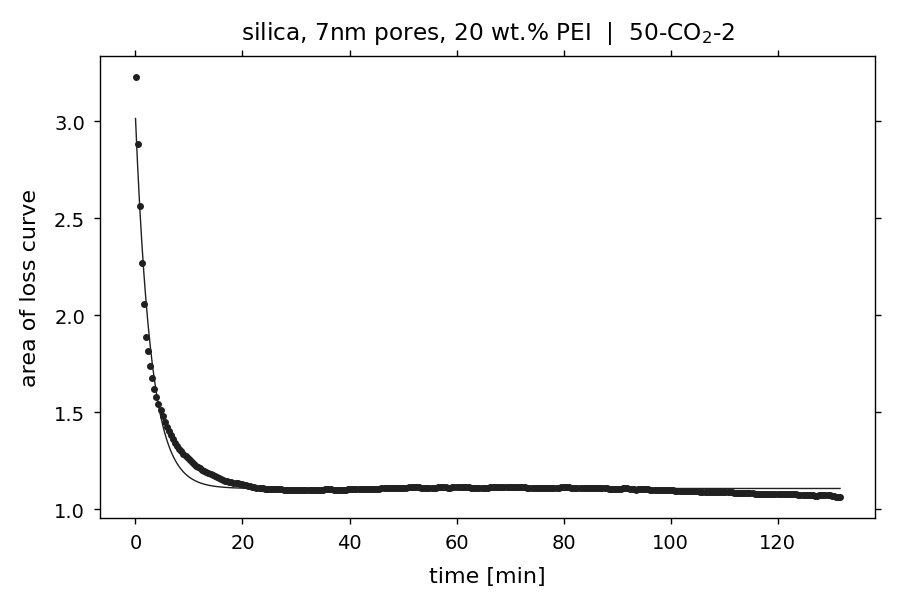

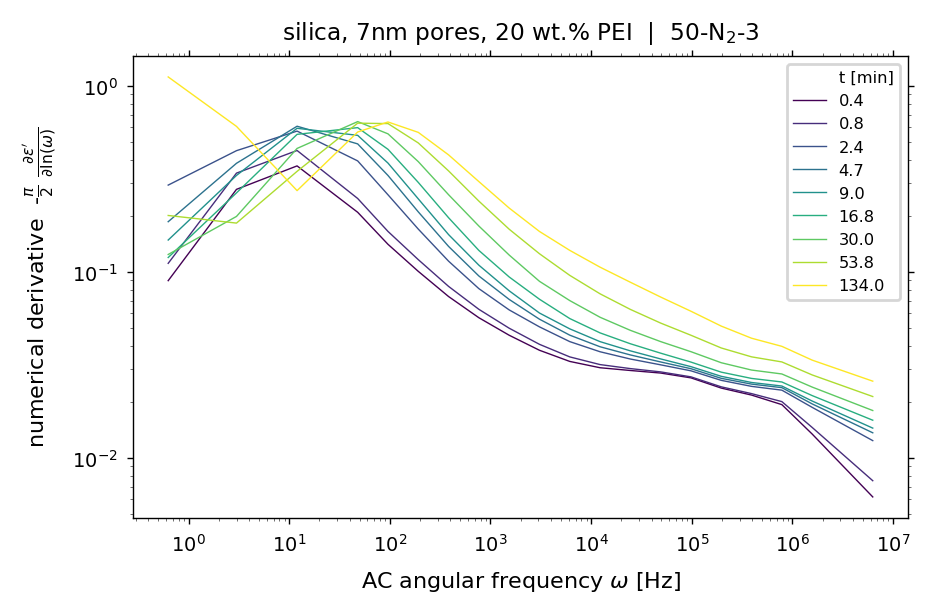

RuntimeError :  Optimal parameters not found: The maximum number of function evaluations is exceeded.


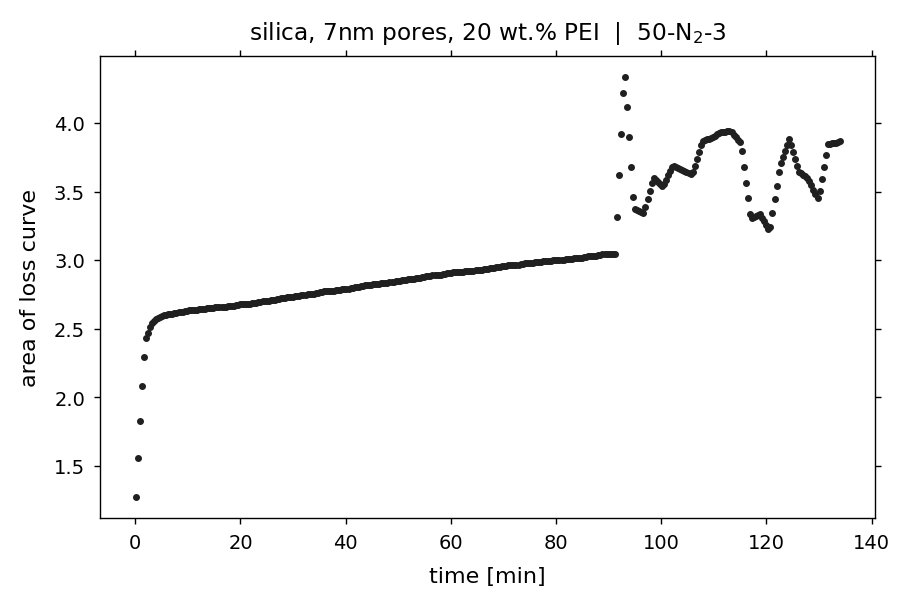

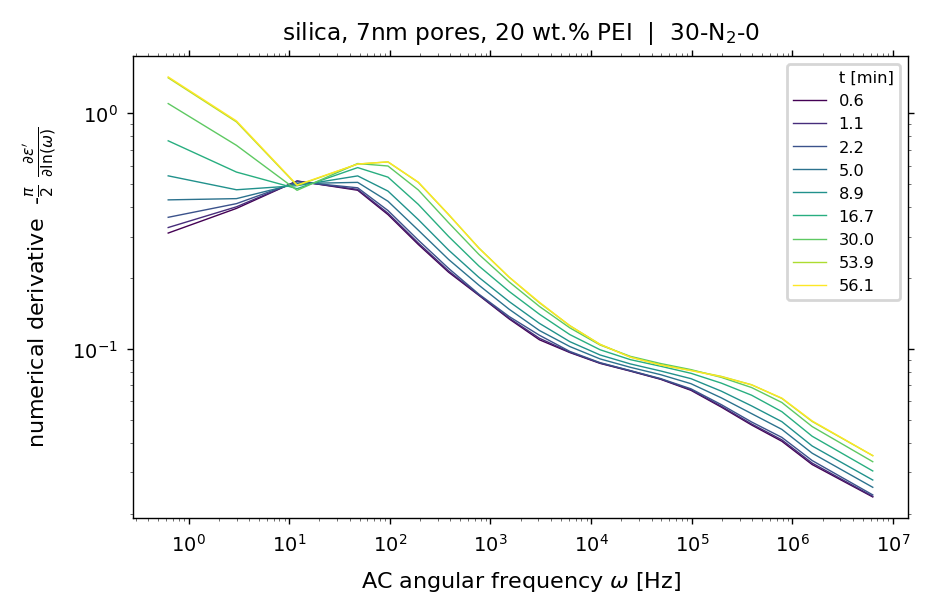

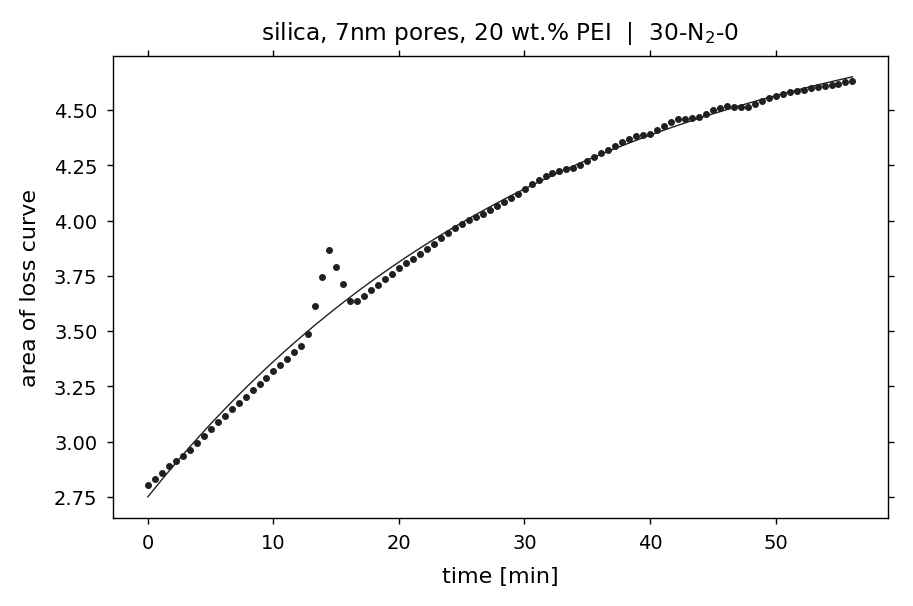

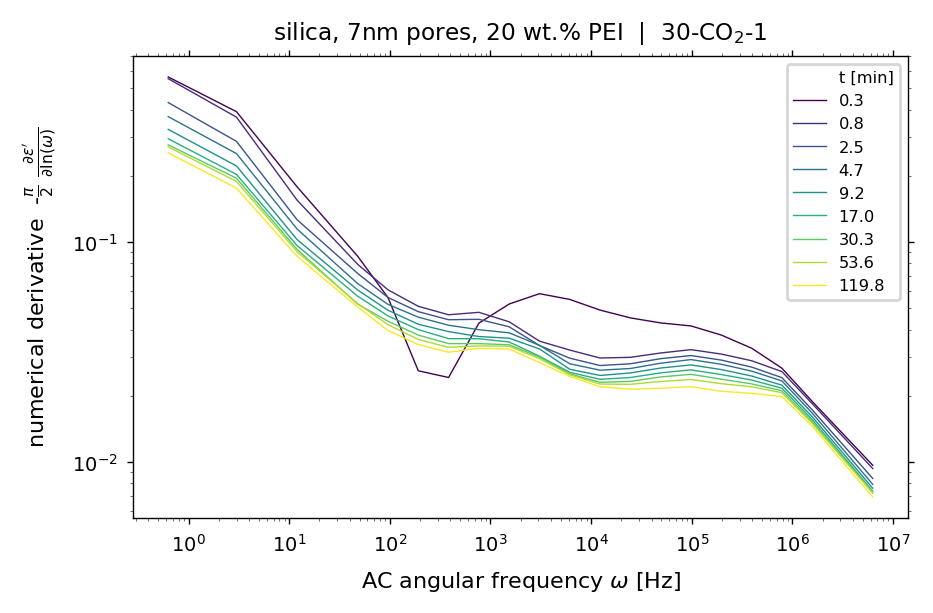

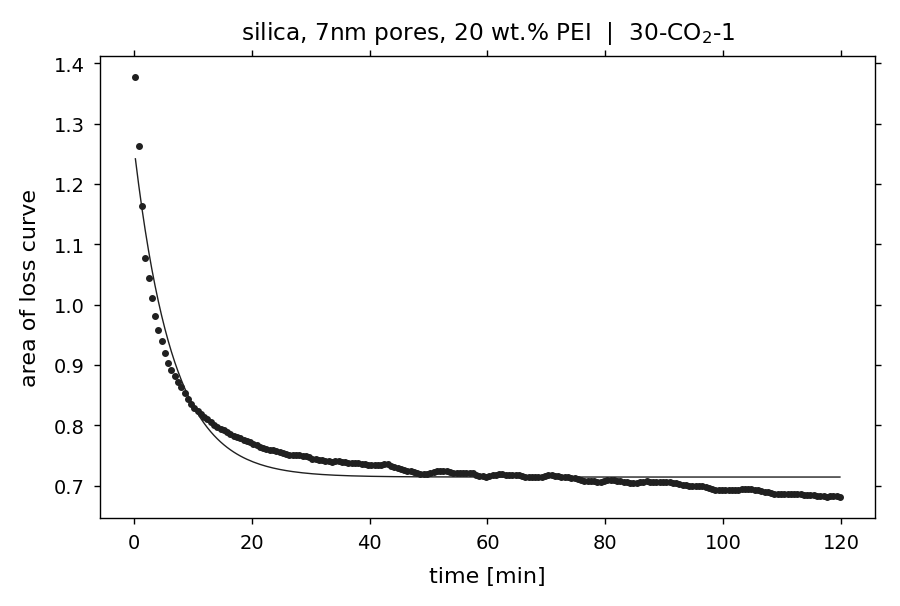

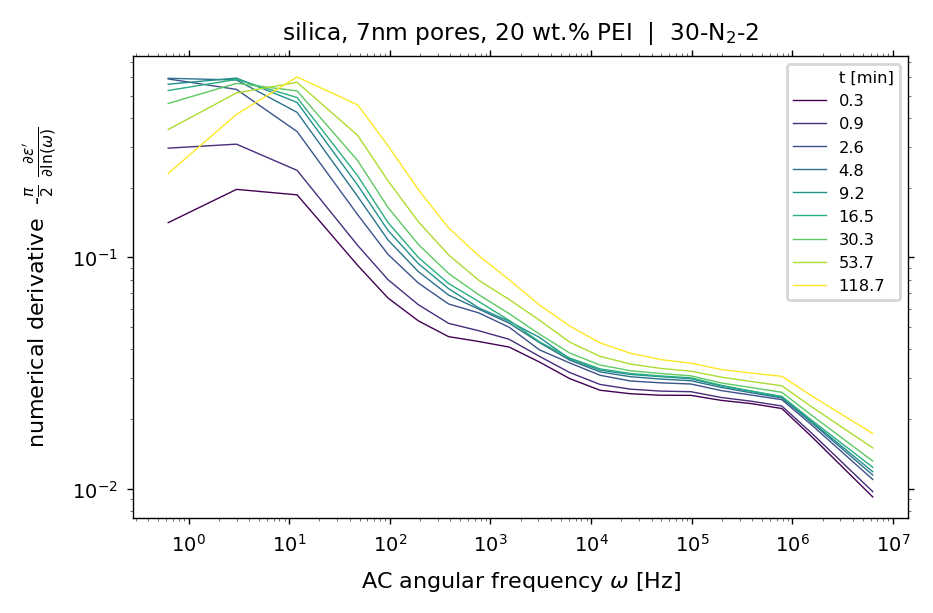

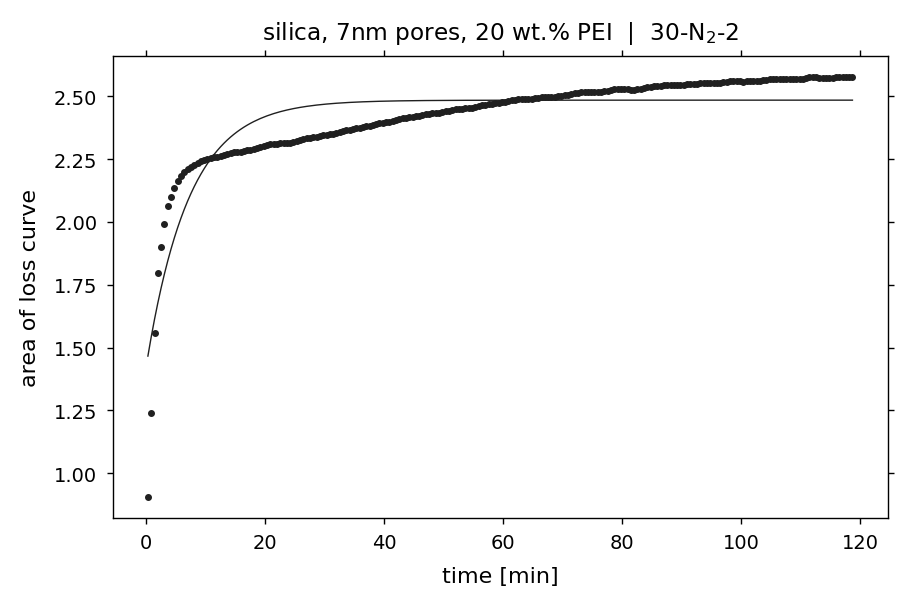

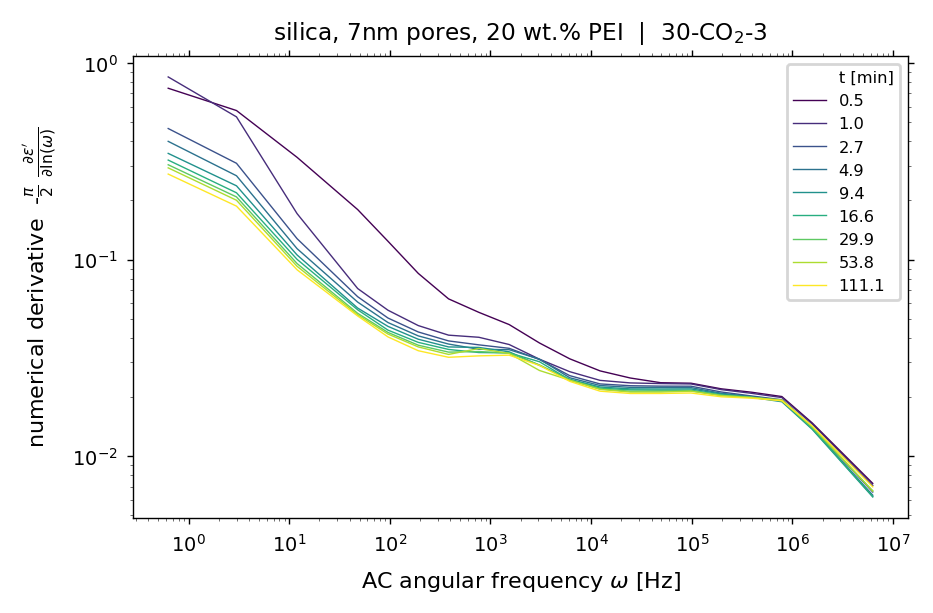

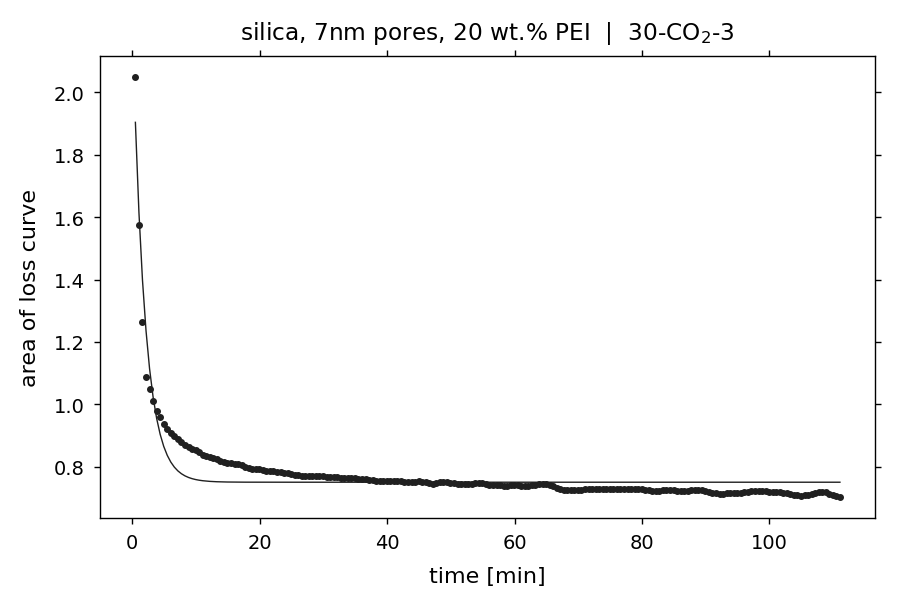

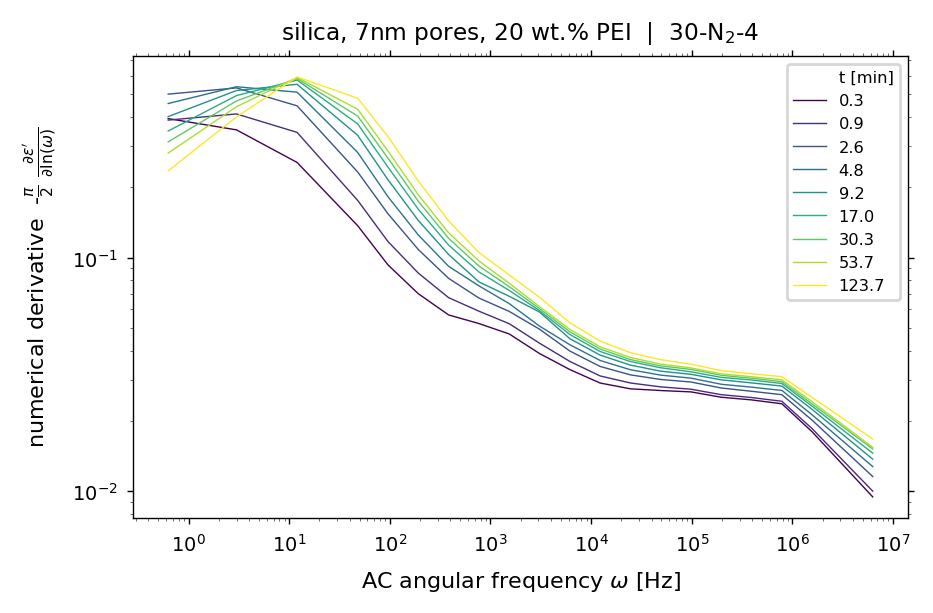

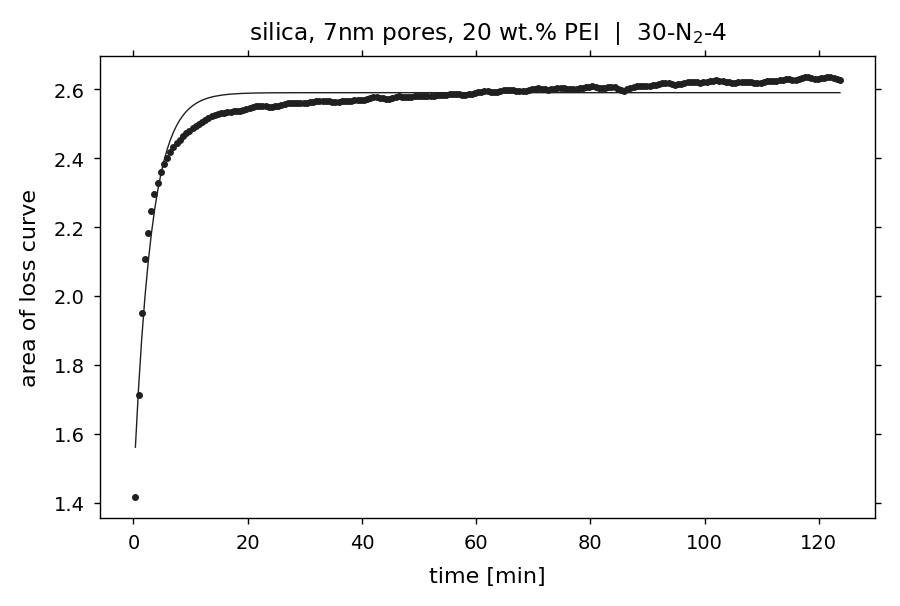

In [4]:
### main
i_ = np.inf
ID = []
# ignore these runs: "tr", where t represents the temperature ({0, 1, 2} -> {70, 50, 30})  and r is the number of the run
idOut = ["10"]
# selection of a few indices where the plot is shown; quadratic: show many at the start and less later
plotI = np.linspace(0,4,8)
plottimes = np.exp( plotI )-1
plottimes = np.append(plottimes, [1e5, 1e5])
tol = 5


# go throgh all temperatures, or rather their respective datasets
for m, data in enumerate(DATA) :
    temp = str(TEMPS[m])

    # f is an array of the unique frequencies
    # er_der is a 2D array of all "numerical derivative of real part"-values
    # er_der[i] (one row of the matrix) is one spectrum
    # where i (one column) corresponds to the time
    # The array contains a whole measurement with fixed temperature and all gas runs
    f, er_der, ei, t = process_and_compute_derivative(data)
    ln_er_der = np.log(er_der)
    w = 2*np.pi*f
    
    # go throgh all runs, one run starts with change of gas
    for j, t0 in enumerate(GASCHANGE[m][:-1]) :
        if str(m)+str(j) in idOut :
            continue
        gas = GASES[S[m][j]]
        ID.append(temp+'-'+gas+'-'+str(j))
        run_num = len(ID) - 1

        t1 = GASCHANGE[m][j+1]-tol
        # indices of start/end of current run
        t0_i = np.searchsorted(t, t0, side="left")
        t1_i = np.searchsorted(t, t1, side="right")
        ploti = 0

        DT, A = [], []


        plt.xscale('log')
        plt.yscale('log')
        plt.plot([],[],color='white',label="t [min]")

        for i in range(t0_i, t1_i) :
            # time relative to change of gas (=start of current run)
            dt = t[i]-t0
            DT.append(dt)
            dt = np.round(dt, 1)

            A.append(np.abs(np.trapezoid(np.log(w), er_der[i])))


            # plot a small selection of spectra
            if dt > plottimes[ploti] or i==t1_i-1 :
                color = plt.cm.viridis(ploti / len(plotI))  
                plt.plot(w, er_der[i], label=str(dt), color=color)
                plt.ylabel("numerical derivative  -$\\frac{\\pi}{2} ~ \\frac{\\partial\\epsilon'}{\\partial\\ln(\\omega)}$")
                ploti += 1

        title = SAMPLE + "  |  "+ ID[-1]
        plt.title(title)
        plt.xlabel("AC angular frequency $\omega$ [Hz]")

        plt.legend(fontsize='small')
        #plt.savefig("specevo/"+ID[-1]+".png", bbox_inches='tight')
        plt.show()

        if gas[0] == "N" :
            fitf = expn
        else :
            fitf = expp

        DT, A = np.array(DT), np.array(A)

        try :
            popt, _ = curve_fit(fitf, DT, A, bounds=((-i_, 0., 0.), (i_, i_, i_)))

            y = fitf(DT, *popt)
            #yp = expp(DT, *popt[:3])
            #yn = expn(DT, *popt[2:])
            plt.plot(DT, y)
            #plt.plot(DT, yp)
            #plt.plot(DT, yn)
        except Exception as err :
            print(str(type(err))[8:-2], ": ", err)

        plt.scatter(DT, A, linewidth=0.5)

        plt.title(title)
        plt.ylabel("area of loss curve")
        plt.xlabel("time [min]")
        plt.show()

/tmp/ipykernel_177251/2208083196.py:19: RuntimeWarning: invalid value encountered in log
  ln_er_der = np.log(er_der)


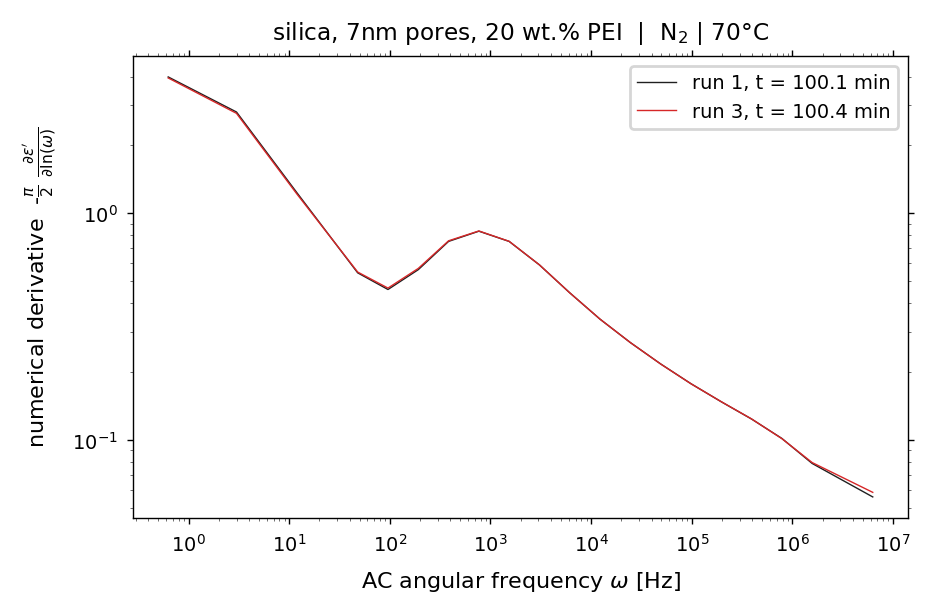

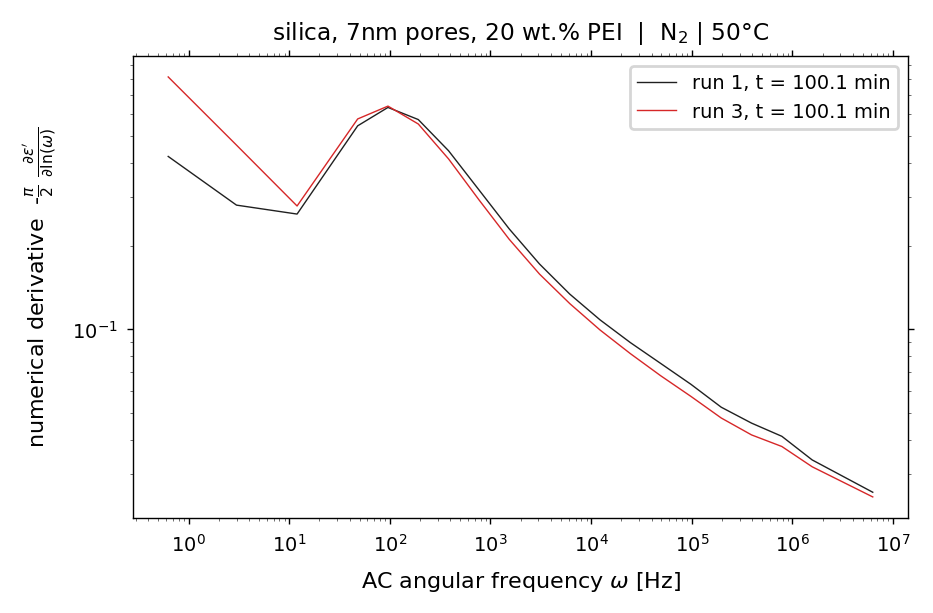

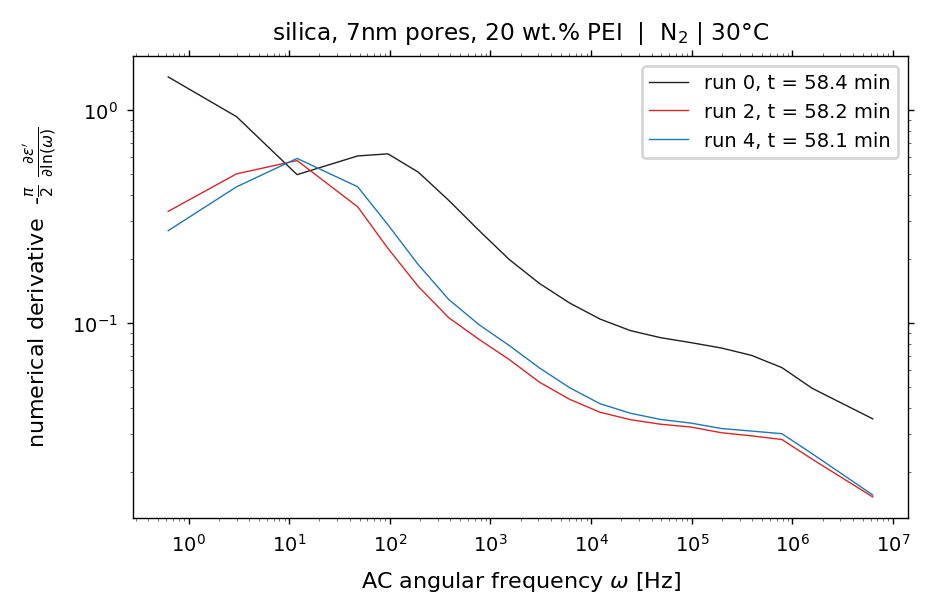

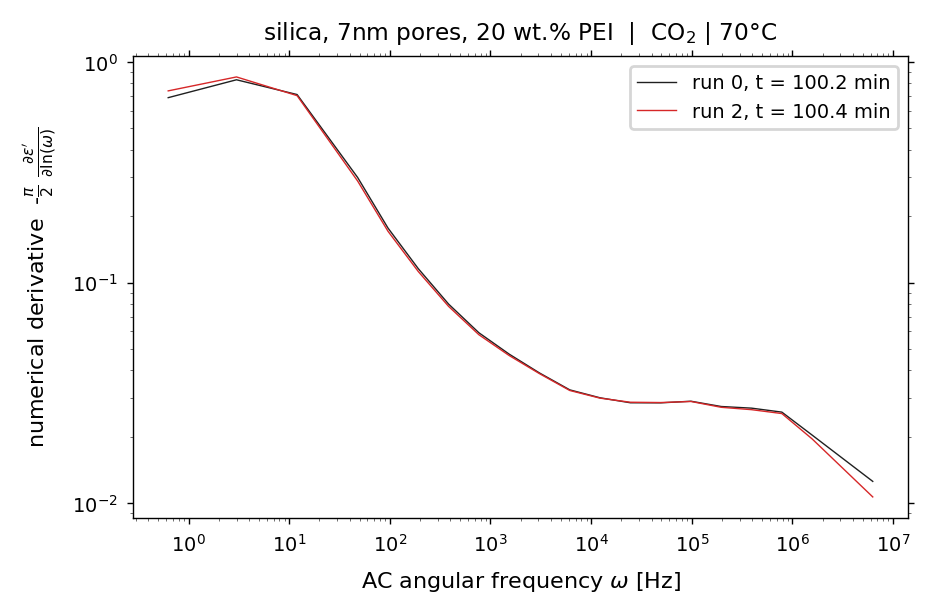

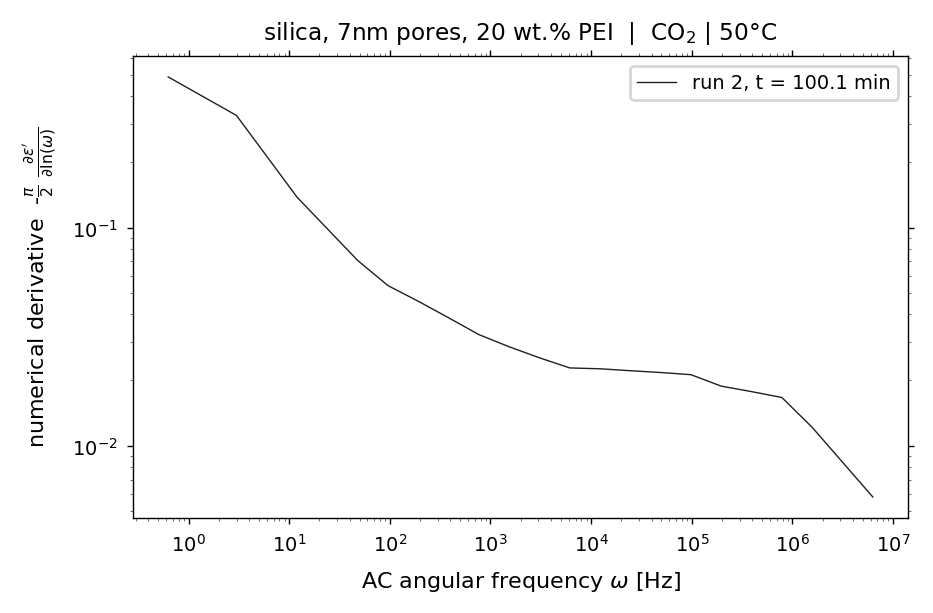

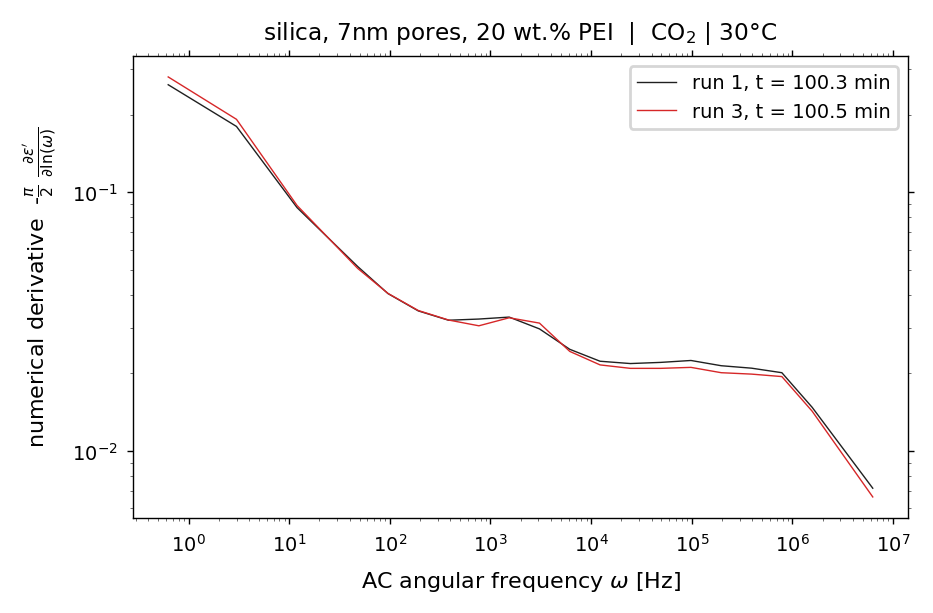

In [5]:
### main

# ignore these runs: "tr", where t represents the temperature ({0, 1, 2} -> {70, 50, 30})  and r is the number of the run
idOut = ["10"]
tol = 2e-2


# go throgh all temperatures, or rather their respective datasets
for g in GASES :
    for m, data in enumerate(DATA) :
        temp = str(TEMPS[m])

        # f is an array of the unique frequencies
        # er_der is a 2D array of all "numerical derivative of real part"-values
        # er_der[i] (one row of the matrix) is one spectrum
        # where i (one column) corresponds to the time
        # The array contains a whole measurement with fixed temperature and all gas runs
        f, er_der, ei, t = process_and_compute_derivative(data)
        ln_er_der = np.log(er_der)
        w = 2*np.pi*f
        
        # go throgh all runs, one run starts with change of gas
        for j, t0 in enumerate(GASCHANGE[m][:-1]-tol) :
            if str(m)+str(j) in idOut :
                continue
            gas = GASES[S[m][j]]
            if gas != g :
                continue
            
            if g[0] == "N" and temp[0] == "3" :
                plot_t = 58
            else :
                plot_t = 100

            t1 = min(t0 + plot_t, GASCHANGE[m][j+1]-tol-3)
            t1_i = np.searchsorted(t, t1, side="right")

            plt.xscale('log')
            plt.yscale('log')

            t_str = str(np.round(t[t1_i]-t0, 1))
            label = "run " + str(j) + ", t = " + t_str + " min"
            plt.plot(w, er_der[t1_i], label=label)
            plt.ylabel("numerical derivative  -$\\frac{\\pi}{2} ~ \\frac{\\partial\\epsilon'}{\\partial\\ln(\\omega)}$")
            #if i==80 :
            #    plt.savefig("results20/"+ID[-1], dpi='figure')


        title = SAMPLE + "  |  "+ g +" | " + temp + "°C"
        plt.title(title)
        plt.xlabel("AC angular frequency $\omega$ [Hz]")

        plt.legend()
        #plt.savefig("runcomp/" + g + "-" + temp, bbox_inches='tight')
        plt.show()